In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import time
import random
from tqdm import tqdm
import os
from gensim.models import KeyedVectors

# 데이터 분석 라이브러리
import numpy as np
import pandas as pd
import pickle
# 케라스 라이브러리
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, Multiply, Concatenate, Dropout, Dense, Conv1D, MaxPooling1D, Dot, Add, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from gensim.models import KeyedVectors
from tensorflow.keras.models import Model
# 데이터 분할 및 인코더
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# 시각화 라이브러
import matplotlib.pyplot as plt

# 성능 평가 라이브러리
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
# seed 설정
def seed_everything(seed: int=42):
  random.seed(seed)      # random 모듈 사용하는 모든 난수
  np.random.seed(seed)      # NumPy 사용하는 모든 난수
  os.environ['PYTHONASHSEED'] = str(seed)      # os.environ : 파이썬 환경 변수 다루는 딕셔너리, PYTHONASHSEED : 파이썬의 해시 함수 시드 설정하는 환경 변수

my_seed = 42
seed_everything(my_seed)

In [ ]:
path = '/content/drive/MyDrive/paper_1/data/video_games_2018'

# 전처리된 데이터 불러오기
- 데이터 프레임으로 병합

In [ ]:
import gzip
import json

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

In [ ]:
df = pd.read_pickle(f'{path}/dataset_1.pkl')
df.head()

,user,item,reviewText,rating
0,107401,11,I oredered this for a daughter who is now 33 a...,5.0
1,47153,11,Well I thought since this idem didn't have any...,5.0
2,1446031,11,"Though this game is older, I absolutely love i...",5.0
3,200275,40,"This game is a bit hard to get the hang of, bu...",5.0
4,220353,40,I played it a while but it was alright. The st...,4.0


In [ ]:
user_df = pd.read_pickle(f'{path}/dataset_2.pkl')
item_df = pd.read_pickle(f'{path}/dataset_3.pkl')

# Word2Vec으로 임베딩
- DeepCoNN은 Word2Vec으로 임베딩

In [ ]:
# Google News Word2Vec 모델 경로
model_path = '/content/drive/MyDrive/paper_1/GoogleNews-vectors-negative300.bin.gz'

# 모델 불러오기
word2vec_model = KeyedVectors.load_word2vec_format(model_path, binary=True)

# 모델이 잘 불러와졌는지 확인
print(word2vec_model.most_similar('king'))

[('kings', 0.7138045430183411), ('queen', 0.6510956883430481), ('monarch', 0.6413194537162781), ('crown_prince', 0.6204220056533813), ('prince', 0.6159993410110474), ('sultan', 0.5864824056625366), ('ruler', 0.5797567367553711), ('princes', 0.5646552443504333), ('Prince_Paras', 0.5432944297790527), ('throne', 0.5422105193138123)]


In [ ]:
def word2vec_embedding(df, text_col, word2vec_model):
    embeddings = []
    text_list = df[text_col].tolist()  # df[text_col]을 모두 한 list로 합치기

    # 텍스트 리스트를 처리하여 임베딩 생성
    for text in tqdm(text_list):
        words = text.split()  # 텍스트를 단어로 분할
        word_vectors = [word2vec_model[word] for word in words if word in word2vec_model]  # 단어를 벡터로 변환

        if len(word_vectors) > 0:
            # 모든 단어 벡터의 평균을 구해 문장 벡터로 사용
            sentence_embedding = np.mean(word_vectors, axis=0)
        else:
            # 단어가 없을 경우 제로 벡터 사용
            sentence_embedding = np.zeros(word2vec_model.vector_size)

        embeddings.append(sentence_embedding)

    # 임베딩 결과를 데이터프레임에 추가
    stacked_embeddings = np.vstack(embeddings)
    df['word2vec_embedding'] = list(stacked_embeddings)

    return df

In [ ]:
# 사용자별로 묶은 DF을 bert
user_df = word2vec_embedding(user_df, 'userReviews',word2vec_model)
user_df.head()

100%|██████████| 59833/59833 [02:08<00:00, 467.20it/s]


,user,userReviews,word2vec_embedding
0,126,Im still not sure why my son plays the old gam...,"[0.031152725219726562, 0.01462385430932045, 0...."
1,148,Very satisfied customer!Very satisfied custome...,"[0.0407932810485363, 0.009845188818871975, 0.0..."
2,156,This game is cool but i hate the fact that you...,"[0.06465929001569748, 0.023948414251208305, 0...."
3,159,It seems to be a good mouse but I have medium ...,"[0.05885721370577812, 0.018396828323602676, 0...."
4,160,This adapter allowed me to connect some old so...,"[0.05386693775653839, -0.0010051786666736007, ..."


In [ ]:
# reviewText 열 제거
user_df = user_df.drop(columns=['userReviews'])
user_df = user_df.rename(columns={'word2vec_embedding': 'user_word2vec'})
user_df.head()

,user,user_word2vec
0,126,"[0.031152725219726562, 0.01462385430932045, 0...."
1,148,"[0.0407932810485363, 0.009845188818871975, 0.0..."
2,156,"[0.06465929001569748, 0.023948414251208305, 0...."
3,159,"[0.05885721370577812, 0.018396828323602676, 0...."
4,160,"[0.05386693775653839, -0.0010051786666736007, ..."


In [ ]:
user_df = pd.DataFrame({
    "user": user_df["user"].values,
    "user_word2vec": user_df["user_word2vec"].values,})

user_df.to_pickle(f'{path}/video_games_word2vec_user.pkl')
user_df = pd.read_pickle(f'{path}/video_games_word2vec_user.pkl')

In [ ]:
# 사용자별로 묶은 DF을 bert
item_df = word2vec_embedding(item_df, 'itemReviews',word2vec_model)
item_df.head()

# reviewText 열 제거
item_df = item_df.drop(columns=['itemReviews'])
item_df = item_df.rename(columns={'word2vec_embedding': 'item_word2vec'})
item_df.head()

item_df = pd.DataFrame({
    "item": item_df["item"].values,
    "item_word2vec": item_df["item_word2vec"].values,})

item_df.to_pickle(f'{path}/video_games_word2vec_item.pkl')
item_df = pd.read_pickle(f'{path}/video_games_word2vec_item.pkl')

100%|██████████| 47061/47061 [02:05<00:00, 376.22it/s]


# 데이터프레임 합치기
- Full DF = User DF(user+user review) + Item DF(item+item reveiw)

In [ ]:
full_df = pd.merge(df, user_df, on='user', how='left')
full_df.head()

,user,item,reviewText,rating,user_word2vec
0,107401,11,I oredered this for a daughter who is now 33 a...,5.0,"[0.047085851430892944, 0.03424350917339325, 0...."
1,47153,11,Well I thought since this idem didn't have any...,5.0,"[0.05362916365265846, 0.02552099898457527, 0.0..."
2,1446031,11,"Though this game is older, I absolutely love i...",5.0,"[0.07747876644134521, 0.04429979622364044, 0.0..."
3,200275,40,"This game is a bit hard to get the hang of, bu...",5.0,"[0.05858432129025459, 0.03188195452094078, 0.0..."
4,220353,40,I played it a while but it was alright. The st...,4.0,"[0.040687479078769684, 0.03475954383611679, 0...."


In [ ]:
full_df = pd.merge(full_df, item_df, on='item', how='left')
full_df.head()

,user,item,reviewText,rating,user_word2vec,item_word2vec
0,107401,11,I oredered this for a daughter who is now 33 a...,5.0,"[0.047085851430892944, 0.03424350917339325, 0....","[0.04568133130669594, 0.036422863602638245, 0...."
1,47153,11,Well I thought since this idem didn't have any...,5.0,"[0.05362916365265846, 0.02552099898457527, 0.0...","[0.04568133130669594, 0.036422863602638245, 0...."
2,1446031,11,"Though this game is older, I absolutely love i...",5.0,"[0.07747876644134521, 0.04429979622364044, 0.0...","[0.04568133130669594, 0.036422863602638245, 0...."
3,200275,40,"This game is a bit hard to get the hang of, bu...",5.0,"[0.05858432129025459, 0.03188195452094078, 0.0...","[0.048237066715955734, 0.03133554756641388, 0...."
4,220353,40,I played it a while but it was alright. The st...,4.0,"[0.040687479078769684, 0.03475954383611679, 0....","[0.048237066715955734, 0.03133554756641388, 0...."


In [ ]:
# reviewText 열 제거
full_df = full_df.drop(columns=['reviewText'])
full_df.head()

,user,item,rating,user_word2vec,item_word2vec
0,107401,11,5.0,"[0.047085851430892944, 0.03424350917339325, 0....","[0.04568133130669594, 0.036422863602638245, 0...."
1,47153,11,5.0,"[0.05362916365265846, 0.02552099898457527, 0.0...","[0.04568133130669594, 0.036422863602638245, 0...."
2,1446031,11,5.0,"[0.07747876644134521, 0.04429979622364044, 0.0...","[0.04568133130669594, 0.036422863602638245, 0...."
3,200275,40,5.0,"[0.05858432129025459, 0.03188195452094078, 0.0...","[0.048237066715955734, 0.03133554756641388, 0...."
4,220353,40,4.0,"[0.040687479078769684, 0.03475954383611679, 0....","[0.048237066715955734, 0.03133554756641388, 0...."


In [ ]:
full_df = pd.DataFrame({
    "user": full_df["user"].values,
    "item": full_df["item"].values,
    "user_word2vec": full_df["user_word2vec"].values,
    "item_word2vec": full_df["item_word2vec"].values,
    "rating": full_df["rating"].values})

full_df.to_pickle(f'{path}/video_games_word2vec.pkl')
full_df = pd.read_pickle(f'{path}/video_games_word2vec.pkl')

# Train/Test 분할

In [ ]:
def split_train_test(df, test_size=0.2, random_state=42):
    while True:
        # 초기 트레인/테스트 분할
        train_df, test_df = train_test_split(df, test_size=test_size, random_state=random_state)

        # test 데이터에 있는 사용자와 아이템이 train 데이터에도 존재하도록 필터링
        test_users = test_df['user'].unique()
        test_items = test_df['item'].unique()

        test_df = test_df[test_df['user'].isin(train_df['user']) & test_df['item'].isin(train_df['item'])]

        # 필터링 후 테스트 데이터셋이 비어 있지 않다면 루프 종료
        if not test_df.empty:
            return train_df, test_df

In [ ]:
# 데이터 세트 분할
train_df, test_df = train_test_split(full_df, test_size=0.2, random_state=42)

In [ ]:
# 학습 데이터셋 준비
train_user = np.array(train_df['user_word2vec'].tolist(), dtype=np.float32)
train_item = np.array(train_df['item_word2vec'].tolist(), dtype=np.float32)
train_y = np.array(train_df['rating'].tolist(), dtype=np.float32)

# 테스트 데이터셋 준비
test_user = np.array(test_df['user_word2vec'].tolist(), dtype=np.float32)
test_item = np.array(test_df['item_word2vec'].tolist(), dtype=np.float32)
test_y = np.array(test_df['rating'].tolist(), dtype=np.float32)

In [ ]:
# 딕셔너리를 pickle 파일로 저장
train_dict = {"train_user": train_df["user"].values,
              "train_item": train_df["item"].values,
              "train_y": train_y,
              "train_user_word2vec": train_user,
              "train_item_word2vec": train_item}

test_dict = {"test_user": test_df["user"].values,
              "test_item": test_df["item"].values,
              "test_y": test_y,
              "test_user_word2vec": test_user,
              "test_item_word2vec": test_item}

# 딕셔너리를 pickle 파일로 저장
with open(f'{path}/video_games_train_dict_word2vec.pkl', 'wb') as f:
    pickle.dump(train_dict, f)

with open(f'{path}/video_games_test_dict_word2vec.pkl', 'wb') as f:
    pickle.dump(test_dict, f)

# Train/Test 데이터 불러오기

In [ ]:
# pickle 파일에서 딕셔너리 불러오기
with open(f'{path}/video_games_train_dict_word2vec.pkl', 'rb') as f:
    train_dict = pickle.load(f)

with open(f'{path}/video_games_test_dict_word2vec.pkl', 'rb') as f:
    test_dict = pickle.load(f)

In [ ]:
train_user = train_dict["train_user"]
train_item = train_dict["train_item"]
train_y = train_dict["train_y"]
train_user_word2vec = train_dict["train_user_word2vec"]
train_item_word2vec = train_dict["train_item_word2vec"]


test_user = test_dict["test_user"]
test_item = test_dict["test_item"]
test_y = test_dict["test_y"]
test_user_word2vec = test_dict["test_user_word2vec"]
test_item_word2vec = test_dict["test_item_word2vec"]

# DeepCoNN 모델

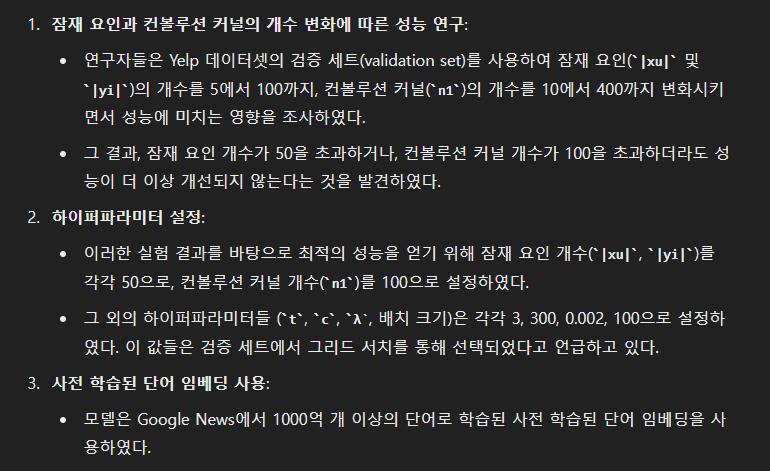

In [ ]:
def Modeling(hidden_size, num_filters, kernel_size, learning_rate):

    # User Input
    user = Input(shape=(300,), dtype='float32')
    user_reshaped = Reshape((300, 1))(user)
    # User CNN
    user_conv = Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu')(user_reshaped)
    # User Maxpooling
    user_pooling = MaxPooling1D()(user_conv)
    user_flat = Flatten()(user_pooling)
    user_output = Dense(hidden_size, name='user_output', activation='relu')(user_flat)
    user_output = Dropout(0.4)(user_output)

    # Item Input
    item = Input(shape=(300,), dtype='float32')
    item_reshaped = Reshape((300, 1))(item)
    # Item CNN
    item_conv = Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu')(item_reshaped)
    # Item Maxpooling
    item_pooling = MaxPooling1D()(item_conv)
    item_flat = Flatten()(item_pooling)
    item_output = Dense(hidden_size, name='item_output', activation='relu')(item_flat)
    item_output = Dropout(0.4)(item_output)

    # Loss function
    # Concatenate user and item outputs to map into the same feature space
    # 특성별 가중치
    user_item_concat = Concatenate()([user_output, item_output])
    user_item_concat = Dense(1, activation='linear', name='concat_dense')(user_item_concat)

    # 상호작용 모델링
    user_item_dot = Dot(axes=1)([user_output, item_output])

    # Final output
    output = Add()([user_item_concat, user_item_dot])

    model = Model(inputs=[user, item], outputs=output)
    return model

In [ ]:
# 하이퍼파라미터 설정
kernel_size = 3
learning_rate = 0.002
num_filters = 100
hidden_size = 50

In [ ]:
model = Modeling(hidden_size, num_filters, kernel_size, learning_rate)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate), loss="mse", metrics=["mse", "mae"])

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 300)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 300)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 300, 1)         │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 300, 1)         │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 298, 100)       │            400 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 298, 100)       │            400 │ reshape_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d             │ (None, 149, 100)       │              0 │ conv1d[0][0]           │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_1           │ (None, 149, 100)       │              0 │ conv1d_1[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 14900)          │              0 │ max_pooling1d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 14900)          │              0 │ max_pooling1d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ user_output (Dense)       │ (None, 50)             │        745,050 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ item_output (Dense)       │ (None, 50)             │        745,050 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 50)             │              0 │ user_output[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 50)             │              0 │ item_output[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 100)            │              0 │ dropout[0][0],         │
│                           │                        │                │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concat_dense (Dense)      │ (None, 1)              │            101 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dot (Dot)                 │ (None, 1)              │              0 │ dropout[0][0],         │
│                           │                        │                │ dropout_1[0][0]        │
├──────────────────────

 Total params: 1,491,001 (5.69 MB)

 Trainable params: 1,491,001 (5.69 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Configuration of EarlyStopping
early_stopping = EarlyStopping(
    monitor ='val_loss',
    min_delta = 0.001,
    patience = 5,
    verbose = 1,
    mode = 'min',          #
    restore_best_weights = True
)

In [ ]:
# 모델 학습
history = model.fit(
    x=[train_user_word2vec, train_item_word2vec],
    y=train_y,
    validation_split=0.125,
    batch_size=100,
    callbacks=[early_stopping],
    epochs=50
)

Epoch 1/50
3816/3816 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 1.9327 - mae: 1.0830 - mse: 1.9327 - val_loss: 1.2083 - val_mae: 0.8088 - val_mse: 1.2083
Epoch 2/50
3816/3816 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 1.3033 - mae: 0.8931 - mse: 1.3033 - val_loss: 1.2010 - val_mae: 0.8782 - val_mse: 1.2010
Epoch 3/50
3816/3816 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 1.2240 - mae: 0.8550 - mse: 1.2240 - val_loss: 1.1799 - val_mae: 0.7902 - val_mse: 1.1799
Epoch 4/50
3816/3816 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 1.2037 - mae: 0.8443 - mse: 1.2037 - val_loss: 1.1836 - val_mae: 0.7859 - val_mse: 1.1836
Epoch 5/50
3816/3816 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 1.2030 - mae: 0.8432 - mse: 1.2030 - val_loss: 1.1863 - val_mae: 0.8667 - val_mse: 1.1863
Epoch 6/50
3816/3816 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 1.2054 - mae: 0.8436 - mse: 1.2054 - val_loss: 1.1587 - val_mae: 0.8215 - val_mse: 1.1587
Epoch 7/50
3816/3816 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 1.1958 - mae: 0.8410 - ms

In [ ]:
# 예측
predictions = model.predict([test_user_word2vec, test_item_word2vec])

# Calculate MAE
MAE = mean_absolute_error(test_y, predictions)
print(f"MAE: {MAE:.3f}")

# Calculate MSE
MSE = mean_squared_error(test_y, predictions)
print(f"MSE: {MSE:.3f}")

# Calculate RMSE
RMSE = np.sqrt(MSE)
print(f"RMSE: {RMSE:.3f}")

# Calculate MAPE
MAPE = mean_absolute_percentage_error(test_y, predictions) * 100
print(f"MAPE: {MAPE:.3f}%")

3407/3407 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
MAE: 0.788
MSE: 1.119
RMSE: 1.058
MAPE: 34.057%
